**Data preprocessing**

In this tutorial, we demonstrate how to prepare the required inputs for training the SVC model, using seqFISH+ data from Eng et al. (2019) as an example.

Preprocessed datasets used in our projectthat are ready to use can be downloaded from: [https://drive.google.com/drive/folders/1G4Nl-As6hXsAh7vHaRJ3vkYv44A-mU5f](https://drive.google.com/drive/folders/1G4Nl-As6hXsAh7vHaRJ3vkYv44A-mU5f)


In [ ]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
import scanpy as sc
from model.utils import *
import warnings
warnings.filterwarnings("ignore")
import natsort
from tqdm import tqdm
import matplotlib.pyplot as plt

**load subcellular ST data**

- `x y`: Cartesian coordinates of a measured transcript within the cell

- `gene`: Gene name of the transcript 

- `cell`: Cell ID that the transcript belongs to 

- `centerX  centerY`: Nuclear center coordinates for the corresponding cell

In [ ]:
data_path = './SVC/' 
dataset = 'data/seqfish' 
data = pd.read_pickle(f"{data_path}{dataset}/seqfish_data_dict.pkl")
seqfish_data = data['data_df']
print(seqfish_data.head())

             x           y           gene cell nucleus batch  umi  centerX  \
0  1217.437557  557.583252  4933401b06rik  5-0      -1     0    1     1003   
1  1096.190309  394.835294  4933401b06rik  5-0       5     0    1     1003   
2  1093.189494  572.832405  4933401b06rik  5-0      -1     0    1     1003   
3  1005.120220  297.196271  4933401b06rik  5-0      -1     0    1     1003   
4  1142.815026  378.376491  4933401b06rik  5-0      -1     0    1     1003   

   centerY        type  sc_total  
0      425  fibroblast     32224  
1      425  fibroblast     32224  
2      425  fibroblast     32224  
3      425  fibroblast     32224  
4      425  fibroblast     32224  


**Gene2vec ortholog mapping and gene filtering**

For mouse data, we mapped the 16,906 Gene2vec genes to mouse orthologs and preserve the common genes.

In [3]:
ref_gene_names = np.loadtxt(f"{data_path}/data/gene2vec/convert_mmu_gene2vec_names.txt", dtype=str).tolist() ## for human data, use gene2vec/gene2vec_names.txt instead
common= list(set(np.array(list(data['gene_list_dict'].values()))[0]).intersection(set(ref_gene_names)))
print("common genes:", len(common))

common genes: 2659


We then selected the top 1,000 most highly expressed genes for model training and downstream analyses.

In [4]:
seqfish_data = seqfish_data[seqfish_data.gene.isin(common)]
high_exp_gene = seqfish_data.groupby(['gene']).count()['x'].sort_values(ascending=False)[:1000]
high_exp_gene_id = np.array(high_exp_gene.index)
gene_names = natsort.natsorted(high_exp_gene_id)
seqfish_data = seqfish_data[seqfish_data.gene.isin(gene_names)]
print("cell number:",seqfish_data.cell.unique().shape[0]) 
print("gene number:",seqfish_data.gene.unique().shape[0])
# np.savetxt(f"{data_path}{dataset}/gene_names.txt", gene_names, fmt='%s')
cell_names = natsort.natsorted(seqfish_data['cell'].unique().tolist())
# np.savetxt(f"{data_path}{dataset}/cell_names.txt", cell_names, fmt='%s')

cell number: 171
gene number: 1000


save the corresponding Gene2Vec vectors

In [ ]:
chosen_indices_ref = []
for i in range(len(gene_names)):
    if gene_names[i] in ref_gene_names:
        index_position = ref_gene_names.index(gene_names[i])
        chosen_indices_ref.append(index_position)
gene2vec_weight = np.load(f'{data_path}/data/gene2vec/gene2vec_16906.npy')
print("gene2vec_weight:", gene2vec_weight.shape)
gene2vec_weight_filtered = gene2vec_weight[chosen_indices_ref]
print("filtered gene2vec_weight:", gene2vec_weight_filtered.shape)
# np.save(f"{data_path}{dataset}/gene2vec_weight_seqfish.npy", gene2vec_weight_filtered)

gene2vec_weight: (16906, 200)
filtered gene2vec_weight: (1000, 200)


**load cell boundary information for each cell**

- `direction_vec`: the angle of transcript relative to the positive x-axis, with the nuclear center as the origin. 

- `distance_to_center`: Euclidean distance between the cell boundary point and nuclear center

In [6]:
cell_mask_contour = pd.read_pickle(f"{data_path}{dataset}/cell_mask_contour_preprocessed.pkl")
print(cell_mask_contour.head())

  cell    x    y  centerX  centerY  direction_vec  distance_to_center
0  0-0  521  496     1079      724         -158.0          602.783543
1  0-0  519  496     1079      724         -158.0          604.635427
2  0-0  517  494     1079      724         -157.5          607.242950
3  0-0  515  494     1079      724         -158.0          609.094410
4  0-0  513  492     1079      724         -157.5          611.702542


**Conduct cell registration procedure**

In [7]:
seqfish_data = register_original_data(seqfish_data, cell_mask_contour)

100%|██████████| 171/171 [07:26<00:00,  2.61s/it]


              x           y  gene cell nucleus batch  umi  centerX  centerY  \
10   828.109167  457.736354  Aatf  5-0      -1     0    1     1003      425   
11  1128.101035  488.990636  Aatf  5-0      -1     0    1     1003      425   
12  1039.856556  294.494083  Aatf  5-0      -1     0    1     1003      425   
13  1182.850103  461.492268  Aatf  5-0      -1     0    1     1003      425   
14   891.607843  440.987851  Aatf  5-0       5     0    1     1003      425   

          type  sc_total  distance_to_center  direction_vec     ratio  \
10  fibroblast     32224          177.928278          169.5  0.667541   
11  fibroblast     32224          140.517153           27.0  0.425739   
12  fibroblast     32224          135.610472          -74.0  0.802344   
13  fibroblast     32224          183.514973           11.5  0.668383   
14  fibroblast     32224          112.533657          172.0  0.409745   

    angle_radians    x_norm    y_norm  
10       2.958333 -0.656363  0.121650  
11    

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


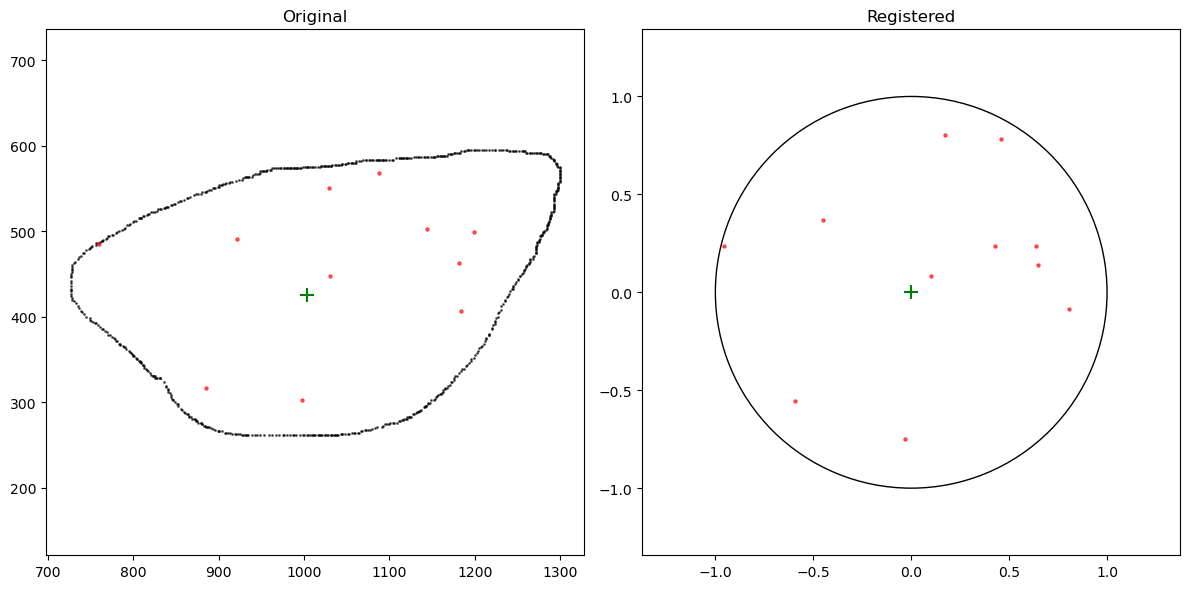

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 
cell_mask_contour_i = cell_mask_contour[(cell_mask_contour.cell == '5-0')]
seqfish_data_i = seqfish_data[(seqfish_data.cell == '5-0')]

axs[0].scatter(cell_mask_contour_i['x'], cell_mask_contour_i['y'], alpha=0.6, s=1, color='black')
axs[0].scatter(seqfish_data_i[(seqfish_data_i.gene == 'Aamp')]['x'], seqfish_data_i[(seqfish_data_i.gene == 'Aamp')]['y'], label='Original Points', alpha=0.6, s=5, color='red')
axs[0].scatter(cell_mask_contour_i['centerX'][0],cell_mask_contour_i['centerY'][0],color='green',s=100,marker='+')
axs[0].axis('equal')
axs[0].set_title('Original') 

axs[1].scatter(seqfish_data_i[(seqfish_data_i.gene == 'Aamp')]['x_norm'], seqfish_data_i[(seqfish_data_i.gene == 'Aamp')]['y_norm'], label='Registered Points', alpha=0.6, s=5, color='red')
circle = plt.Circle((0, 0), 1, fill=False)  
axs[1].add_artist(circle) 
axs[1].set_title('Registered') 
axs[1].scatter(0,0,color='green',s=100,marker='+')
axs[1].axis('equal')
axs[1].set_xlim(-1.5, 1.5)
axs[1].set_ylim(-1.5, 1.5)
plt.tight_layout()

plt.show()

Represent the subcellular spatial expression of each cell and gene as a 48×48-pixel square image, and conduct resolution reduction

In [9]:
map_all_genes = get_gene_map(seqfish_data, cell_names, gene_names)

======> Loading transcripts file
1000 unique genes
171 unique cells
Converting to expression maps


100%|██████████| 171/171 [17:25<00:00,  6.12s/it]


In [ ]:
print("map_all_genes shape:", map_all_genes.shape) 
# np.savez_compressed(f"{data_path}{dataset}/cell_gene_map.npz", image=map_all_genes)

map_all_genes_low_res = map_all_genes.reshape(map_all_genes.shape[0], 12, 4, 12, 4,map_all_genes.shape[-1]).sum(axis=(2, 4))
print(map_all_genes_low_res.shape)
map_all_genes_low_res = np.transpose(map_all_genes_low_res, (0,3,1,2))
print("map_all_genes shape:", map_all_genes_low_res.shape)
# np.savez_compressed(f"{data_path}{dataset}/cell_gene_map_low_res.npz", image=map_all_genes_low_res)

map_all_genes shape: (171, 48, 48, 1000)
(171, 12, 12, 1000)
map_all_genes shape: (171, 1000, 12, 12)


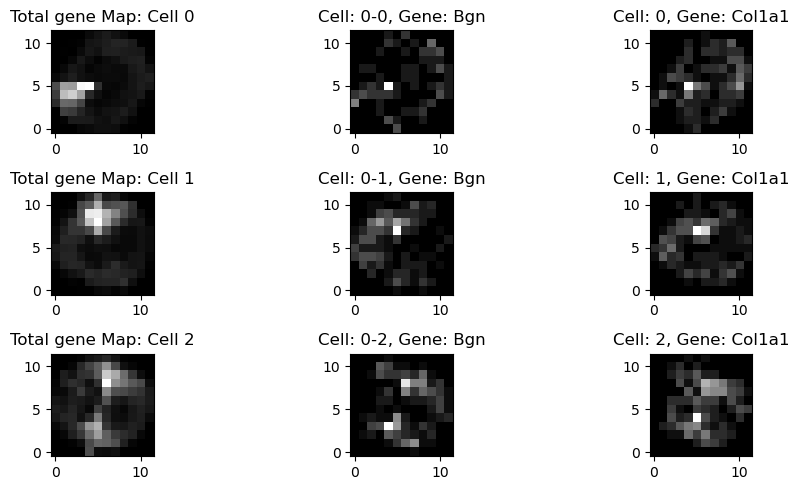

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(10, 5))
cell_id = [0,1,2]
i = 0
for cell in cell_id:
    cell_gene = map_all_genes_low_res[cell]
    cell_gene_sum = cell_gene.sum(axis = 0)
    counts = np.sum(cell_gene, axis=(0, 1))
    ax[i,0].imshow(cell_gene_sum, cmap='gray')
    ax[i,0].set_title("Total gene Map: Cell " + str(cell))
    ax[i,0].invert_yaxis()
    ax[i,1].imshow(cell_gene[gene_names.index('Bgn'),:,:,], cmap='gray')
    ax[i,1].set_title("Cell: " + cell_names[cell] + ", Gene: " + 'Bgn')
    ax[i,1].invert_yaxis()
    ax[i,2].imshow(cell_gene[gene_names.index('Col1a1'),:,:,], cmap='gray')
    ax[i,2].set_title("Cell: " + str(cell) + ", Gene: " + 'Col1a1')
    ax[i,2].invert_yaxis()
    i+=1
plt.tight_layout()

plt.show()
plt.close()
